In [1]:
import os
os.chdir('/home/reinfris/Repos/MPC')

In [2]:
from git import Repo
import subprocess

cwd = os.getcwd()

acados_path = os.path.join(cwd, 'acados')
build_path = os.path.join(acados_path, 'build')
acados_template_path = os.path.join(acados_path, 'interfaces', 'acados_template')

# try:
#     repo = Repo.clone_from('https://github.com/acados/acados.git', acados_path)
#     output = repo.git.submodule('update', '--recursive', '--init')
# except:
#     pass

# if not os.path.isdir(build_path):
#     os.mkdir(build_path)

# os.chdir(build_path)

# print('go to ', build_path)

# subprocess.run(['cmake','-DACADOS_WITH_QPOASES=ON', '..'], stdout=subprocess.PIPE, text=True)
# subprocess.run(['make','install', '-j4'], stdout=subprocess.PIPE, text=True)
# os.chdir(cwd)
# subprocess.run(['pipenv', 'install', '--skip-lock', acados_template_path], stdout=subprocess.PIPE, text=True)

# print('export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:'"'{acados_path}/lib'"'')
# print('export ACADOS_SOURCE_DIR='"'{acados_path}'"'') 

# # export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:"/usr/bin/acados/acados/lib"; export ACADOS_SOURCE_DIR="/usr/bin/acados/acados"

In [3]:
import numpy as np
import sympy as sp
import sys
# from casadi import *
import casadi as cs
from acados_template import AcadosOcp, AcadosOcpSolver, AcadosModel
from scipy.linalg import block_diag
from scipy.integrate import odeint
import do_mpc

import matplotlib.pyplot as plt
import matplotlib as mpl

In [4]:
def skew_symmetric(v):
    """
    Computes the skew-symmetric matrix of a 3D vector (PAMPC version)
    :param v: 3D numpy vector or CasADi MX
    :return: the corresponding skew-symmetric matrix of v with the same data type as v
    """

    return np.array([[0, -v[0], -v[1], -v[2]],
                      [v[0], 0, v[2], -v[1]],
                      [v[1], -v[2], 0, v[0]],
                      [v[2], v[1], -v[0], 0]])
    
def kronecker(p):
    p0, p1, p2, p3 = p
    return sp.Matrix(
        [
            [p0, -p1, -p2, -p3],
            [p1, p0, p3, -p2],
            [p2, -p3, p0, p1],
            [p3, p2, -p1, p0]
        ]
    )

def q_to_rot_mat(q):
    qw, qx, qy, qz = q[0], q[1], q[2], q[3]

    rot_mat = sp.Matrix([
        [1 - 2 * (qy ** 2 + qz ** 2), 2 * (qx * qy - qw * qz), 2 * (qx * qz + qw * qy)],
        [2 * (qx * qy + qw * qz), 1 - 2 * (qx ** 2 + qz ** 2), 2 * (qy * qz - qw * qx)],
        [2 * (qx * qz - qw * qy), 2 * (qy * qz + qw * qx), 1 - 2 * (qx ** 2 + qy ** 2)]])

    return rot_mat


def v_dot_q(v, q):
    rot_mat = q_to_rot_mat(q)
    if isinstance(q, np.ndarray):
        return rot_mat.dot(v)

    return cs.mtimes(rot_mat, v)


def normalize(*args):
    arr = np.array(args)
    return np.divide(arr, np.linalg.norm(arr))


def quaternion_inverse(q):
    w, x, y, z = q[0], q[1], q[2], q[3]

    if isinstance(q, np.ndarray):
        return np.array([w, -x, -y, -z])
    else:
        return cs.vertcat(w, -x, -y, -z)

In [5]:
def sympy_to_str(exprs=[], names=[], subs=None):
  assert len(exprs) == len(names)
  all_expr = [] #sp.Matrix([*exprs])
  for expr in exprs:
    if subs is not None:
      expr = expr.subs(subs)
    all_expr.append(np.array(expr).reshape(expr.shape))
  
  return {n: e.tolist() for n, e in zip(names, all_expr)}

def all_sympy_variables_to_str(*args):
  all_symbols = [[j.name for j in i.free_symbols] for i in sp.Matrix([*args])]
  
  all_symbols_unpacked = []
  for symbols in all_symbols:
    all_symbols_unpacked.extend(symbols)
  
  return sorted(list(set(all_symbols_unpacked)))


In [6]:
def sympy_to_casadi(sp_expr):
  def sympy2casadi(sympy_expr, sympy_var, casadi_var):
    assert casadi_var.is_vector()
    if casadi_var.shape[1]>1:
      casadi_var = casadi_var.T
    casadi_var = cs.vertsplit(casadi_var)

    mapping = {'ImmutableDenseMatrix': cs.blockcat,
              'MutableDenseMatrix': cs.blockcat,
              'Abs':cs.fabs
              }

    f = sp.lambdify(sympy_var, sympy_expr, modules=[mapping, cs])
    return f(*casadi_var)

  
  shape = np.array(sp_expr).shape
  if isinstance(sp_expr, list):
    flattened_list = list(np.concatenate(sp_expr). flat)
  
  casadi_list = []
  for sp_expr_i in flattened_list:
    sp_vars = [var.name for var in sp_expr_i.free_symbols]
    if not sp_vars:
      constant = float(sp_expr_i)
      casadi_list.append(constant)
    else:
      sp_vars_vec = sp.Matrix([sp.symbols(var) for var in sp_vars])
      cas_vars_vec = cs.vertcat(*[cs.SX.sym(var) for var in sp_vars])
      expression = sympy2casadi(sp_expr_i, sp_vars_vec, cas_vars_vec)
      casadi_list.append(expression)

  total = cs.vertcat(*casadi_list)
  return cs.reshape(total, shape[0], shape[1])

In [7]:

# Quadrotor dynamics quaternions

# https://dh8.kr/workshop/sejong_control/Handbook_of_Unmanned_Aerial_Vehicles.pdf chapter 16 Quadrotor Kinematics and Dynamics
# https://www.diva-portal.org/smash/get/diva2:1010947/FULLTEXT01.pdf

g = sp.symbols('g')
m = sp.Symbol('m')
L, kf, km, ct = sp.symbols('L, kf, km, ct') # Length arm, yps=kf/km, 
ix, iy, iz = sp.symbols('ix, iy, iz')

T0, T1, T2, T3 = sp.symbols('T0, T1, T2, T3')
T = sp.Matrix([T0, T1, T2, T3])

xf = sp.Matrix([L, 0, -L, 0])
yf = sp.Matrix([0, L, 0, -L])

I = sp.Matrix([[ix, 0, 0], [0, iy, 0], [0, 0, iz]])
inv_I = I.inv()

x, y, z = sp.symbols('x, y, z')
r = sp.Matrix([x, y, z])

dx, dy, dz = sp.symbols('dx, dy, dz')
v = sp.Matrix([dx, dy, dz])

wx, wy, wz = sp.symbols('wx, wy, wz')
ohm = sp.Matrix([wx, wy, wz])

# rigid body dynamics

U = T0 + T1 + T2 + T3

tx = T.dot(yf)
ty = T.dot(xf)
tz = T.dot([-ct, ct, -ct, ct])

tau = sp.Matrix([tx, ty, tz])

q0, q1, q2, q3 = sp.symbols('q0, q1, q2, q3')
rot = q_to_rot_mat([q0, q1, q2, q3])
q = sp.Matrix([q0, q1, q2, q3])

pdot = v
qdot = 0.5 * kronecker([0, wx, wy, wz]) @ q
vdot = sp.Matrix([0, 0, -g]) + 1/m * rot @ (sp.Matrix([0, 0, U])) # - 0.1*np.array([dx**2, dy**2, dz**2])[:, np.newaxis]
ohmdot = inv_I @ tau - inv_I @ (ohm.cross(I @ ohm))

eom_jac = sp.simplify(sp.Matrix([pdot, qdot, vdot, ohmdot]).jacobian(sp.Matrix([r, q, v, ohm])))

odes = [
    (pdot, [dx, dy, dz], 'pdot'),
    (qdot, [q0, q1, q2, q3, wx, wy, wz], 'qdot'),
    (vdot, [q0, q1, q2, q3, T0, T1, T2, T3, g, m], 'vdot'),
    (ohmdot, [wx, wy, wz, T0, T1, T2, T3, ix, iy, iz, L, ct], 'ohmdot'),
    (eom_jac, [q0, q1, q2, q3, wx, wy, wz, T0, T1, T2, T3, ix, iy, iz, m], 'eom_jac')
    ]

eom_funs = {val[2]: sp.lambdify(val[1], val[0]) for val in odes}


In [8]:
class Quadrotor3D:

    def __init__(self, noisy=False, drag=False, payload=False, motor_noise=False):
        # Maximum thrust in Newtons of a thruster when rotating at maximum speed.
        self.max_thrust = 20

        # System state space
        self.pos = np.zeros((3,))
        self.vel = np.zeros((3,))
        self.angle = np.array([1., 0., 0., 0.])  # Quaternion format: qw, qx, qy, qz
        self.a_rate = np.zeros((3,))

        # Input constraints
        self.max_input_value = 1  # Motors at full thrust
        self.min_input_value = 0  # Motors turned off

        # Quadrotor intrinsic parameters
        self.ix, self.iy, self.iz = [.03, .03, .06]
        self.mass = 1.0  # kg

        # Length of motor to CoG segment
        self.length = 0.47 / 2  # m

        self.x_f = np.array([self.length, 0, -self.length, 0])
        self.y_f = np.array([0, self.length, 0, -self.length])

        # For z thrust torque calculation
        self.ct = 0.013  # m   (z torque generated by each motor)

        # Gravity vector
        self.g = 9.81 # m s^-2

        # Actuation thrusts
        self.u_noiseless = np.array([0.0, 0.0, 0.0, 0.0])
        self.u = np.array([0.0, 0.0, 0.0, 0.0])  # N

        # Drag coefficients [kg / m]
        self.rotor_drag_xy = 0.3
        self.rotor_drag_z = 0.0  # No rotor drag in the z dimension
        self.rotor_drag = np.array([self.rotor_drag_xy, self.rotor_drag_xy, self.rotor_drag_z])[:, np.newaxis]
        self.aero_drag = 0.08

        self.drag = drag
        self.noisy = noisy
        self.motor_noise = motor_noise

        self.payload_mass = 0.3  # kg
        self.payload_mass = self.payload_mass * payload

    def set_state(self, **kwargs):
        self.pos = kwargs["pos"]
        self.angle = kwargs["angle"]
        self.vel = kwargs["vel"]
        self.a_rate = kwargs["rate"]

    def set_state_from_array(self, state):
        self.pos = np.array(state[0:3])
        self.angle = np.array(state[3:7])
        self.vel = np.array(state[7:10])
        self.a_rate = np.array(state[10:13])

    def get_state(self, stacked=False):
        if stacked:
            return [self.pos, self.angle, self.vel, self.a_rate]
        else:
            return np.array([self.pos[0], self.pos[1], self.pos[2], self.angle[0], self.angle[1], self.angle[2], self.angle[3],
                    self.vel[0], self.vel[1], self.vel[2], self.a_rate[0], self.a_rate[1], self.a_rate[2]])

    def get_control(self, noisy=False):
        if not noisy:
            return self.u_noiseless
        else:
            return self.u

    def update(self, u, dt=0.04):

        if isinstance(u, np.ndarray):
            u = u.flatten()

        # Clip inputs
        for i, u_i in enumerate(u):
            self.u_noiseless[i] = max(min(u_i, self.max_input_value), self.min_input_value)

        # Apply noise to inputs (uniformly distributed noise with standard deviation proportional to input magnitude)
        if self.motor_noise:
            for i, u_i in enumerate(self.u_noiseless):
                std = 0.02 * sqrt(u_i)
                noise_u = np.random.normal(loc=0.1 * (u_i / 1.3) ** 2, scale=std)
                self.u[i] = max(min(u_i - noise_u, self.max_input_value), self.min_input_value) * self.max_thrust
        else:
            self.u = self.u_noiseless * self.max_thrust

        # Generate disturbance forces / torques
        if self.noisy:
            f_d = np.random.normal(size=(3, 1), scale=10 * dt)
            t_d = np.random.normal(size=(3, 1), scale=10 * dt)
        else:
            f_d = np.zeros((3, 1))
            t_d = np.zeros((3, 1))

        x = self.get_state()

        def wrapper(x, t, u):
            pos = self.f_pos(x)
            att = self.f_att(x)
            vel = self.f_vel(x, u)
            rate = self.f_rate(x, u)        
            return np.array([*pos, *att, *vel, *rate])

        updates = odeint(wrapper, x, [0., dt], args=(self.u, ))[-1]
        
        # Ensure unit quaternion
        updates[3:7] = normalize(*updates[3:7])

        self.set_state_from_array(updates)

    def f_pos(self, x, u=None):
        x, y, z, q0, q1, q2, q3, dx, dy, dz, wx, wy, wz = x
        output = eom_funs['pdot'](dx, dy, dz)
        return output.squeeze()

    def f_att(self, x, u=None):
        x, y, z, q0, q1, q2, q3, dx, dy, dz, wx, wy, wz = x
        output = eom_funs['qdot'](q0, q1, q2, q3, wx, wy, wz)
        return output.squeeze()

    def f_vel(self, x, u):
        x, y, z, q0, q1, q2, q3, dx, dy, dz, wx, wy, wz = x
        u0, u1, u2, u3 = u
        output = eom_funs['vdot'](q0, q1, q2, q3, u0, u1, u2, u3, self.g, self.mass)
        return output.squeeze()

    def f_rate(self, x, u):
        x, y, z, q0, q1, q2, q3, dx, dy, dz, wx, wy, wz = x
        u0, u1, u2, u3 = u
        output = eom_funs['ohmdot'](wx, wy, wz, u0, u1, u2, u3, self.ix, self.iy, self.iz, self.length, self.ct)
        return output.squeeze()



In [9]:
qr = Quadrotor3D()
qr.update([1,1,1,1])
qr.vel

array([0.    , 0.    , 2.8076])

In [10]:
model_type = 'continuous' # either 'discrete' or 'continuous'
model = do_mpc.model.Model(model_type)

In [11]:
import os
import sys
import shutil
import casadi as cs
import numpy as np
from copy import copy



def get_angle(t):
      return (2 * np.pi * t/20) % (2 * np.pi)

class Quad3DOptimizer:
    def __init__(self, quad, t_horizon=1, n_nodes=20,
                 q_cost=None, r_cost=None, q_mask=None,
                 B_x=None, model_name="quad_3d_acados_mpc", solver_options=None):
        # Weighted squared error loss function q = (p_xyz, a_xyz, v_xyz, r_xyz), r = (u1, u2, u3, u4)
        self.symbols_state = ['x', 'y', 'z', 'q0', 'q1', 'q2', 'q3', 'dx', 'dy', 'dz', 'wx', 'wy', 'wz']
        self.symbols_input = ['u0', 'u1', 'u2', 'u3']
        
        if q_cost is None:
            q_cost = np.array([10, 10, 10, 0.1, 0.1, 0.1, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05])
        if r_cost is None:
            r_cost = np.array([0.1, 0.1, 0.1, 0.1])

        self.q_diagonal = np.concatenate((q_cost[:3], np.mean(q_cost[3:6])[np.newaxis], q_cost[3:]))
        self.r_diagonal = r_cost

        self.T = t_horizon  # Time horizon
        self.N = n_nodes  # number of control nodes within horizon

        self.t_step = t_horizon/n_nodes

        self.quad = quad

        self.max_u = quad.max_input_value
        self.min_u = quad.min_input_value

        self.g = quad.g
        self.mass = quad.mass
        self.length = quad.length
        
        self.ct = quad.ct
        self.ix = quad.ix
        self.iy = quad.iy
        self.iz = quad.iz

        self.max_thrust = quad.max_thrust

        self.init_state_and_input()
        self.sympy_expressions()

        self.init_do_mpc()

    def sympy_expressions(self):
        exprs = [pdot, qdot, vdot, ohmdot, eom_jac]
        names = ['pdot', 'qdot', 'vdot', 'ohmdot', 'eom_jac']
        u0, u1, u2, u3 = sp.symbols('u0, u1, u2, u3')
        subs = [(L, self.length), (m, self.mass), (g, self.g), (ct, self.ct), 
                (ix, self.ix), (iy, self.iy), (iz, self.iz), 
                (T0, self.max_thrust * u0), (T1, self.max_thrust * u1), 
                (T2, self.max_thrust * u2), (T3, self.max_thrust * u3)]
        self.expressions = sympy_to_str(exprs=exprs, names=names, subs=subs)

    def init_state_and_input(self):
        x = cs.SX.sym('x') 
        y = cs.SX.sym('y') 
        z = cs.SX.sym('z') 
        q0 = cs.SX.sym('q0') 
        q1 = cs.SX.sym('q1') 
        q2 = cs.SX.sym('q2') 
        q3 = cs.SX.sym('q3') 
        dx = cs.SX.sym('dx') 
        dy = cs.SX.sym('dy') 
        dz = cs.SX.sym('dz') 
        wx = cs.SX.sym('wx') 
        wy = cs.SX.sym('wy') 
        wz = cs.SX.sym('wz') 

        self.x = cs.vertcat(x, y, z, q0, q1, q2, q3, dx, dy, dz, wx, wy, wz)#

        x_dot = cs.SX.sym('x_dot') 
        y_dot = cs.SX.sym('y_dot') 
        z_dot = cs.SX.sym('z_dot') 
        q0_dot = cs.SX.sym('q0_dot') 
        q1_dot = cs.SX.sym('q1_dot') 
        q2_dot = cs.SX.sym('q2_dot') 
        q3_dot = cs.SX.sym('q3_dot') 
        dx_dot = cs.SX.sym('dx_dot') 
        dy_dot = cs.SX.sym('dy_dot') 
        dz_dot = cs.SX.sym('dz_dot') 
        wx_dot = cs.SX.sym('wx_dot') 
        wy_dot = cs.SX.sym('wy_dot') 
        wz_dot = cs.SX.sym('wz_dot') 
        
        self.x_dot = cs.vertcat(x_dot, y_dot ,z_dot ,q0_dot ,q1_dot ,q2_dot ,q3_dot ,dx_dot ,dy_dot ,dz_dot ,wx_dot ,wy_dot ,wz_dot)#

        u0 = cs.SX.sym('u0') 
        u1 = cs.SX.sym('u1') 
        u2 = cs.SX.sym('u2') 
        u3 = cs.SX.sym('u3') 
        
        self.u = cs.vertcat(u0, u1, u2, u3)#

    def quad_dynamics(self, return_fun=True):
        x_dot = cs.vertcat(self.p_dynamics(), self.q_dynamics(), self.v_dynamics(), self.w_dynamics())
        return cs.Function('x_dot', [self.x, self.u], [x_dot], ['x', 'u'], ['x_dot']) if return_fun else x_dot

    def p_dynamics(self):
        dx, dy, dz = self.x[7], self.x[8], self.x[9]
        pos_expr = self.expressions['pdot']
        return sympy_to_casadi(pos_expr)

    def q_dynamics(self):
        rot_expr = self.expressions['qdot']
        return sympy_to_casadi(rot_expr)

    def v_dynamics(self):
        vel_expr = self.expressions['vdot']
        return sympy_to_casadi(vel_expr)

    def w_dynamics(self):
        ohm_expr = self.expressions['ohmdot']
        return sympy_to_casadi(ohm_expr)

    def linearized_quad_dynamics(self):
        jac = self.expressions['eom_jac']
        jac_eqs = sympy_to_casadi(jac)
        return cs.Function('J', [self.x, self.u], [jac_eqs])

    def init_do_mpc(self, continuous=True):
        model_type = 'continuous' if continuous else 'discrete'
        model = do_mpc.model.Model(model_type)

        x = model.set_variable('_x',  'x')
        y = model.set_variable('_x',  'y')
        z = model.set_variable('_x',  'z')
        q0 = model.set_variable('_x', 'q0')
        q1 = model.set_variable('_x', 'q1')
        q2 = model.set_variable('_x', 'q2')
        q3 = model.set_variable('_x', 'q3')
        dx = model.set_variable('_x', 'dx')
        dy = model.set_variable('_x', 'dy')
        dz = model.set_variable('_x', 'dz')
        wx = model.set_variable('_x', 'wx')
        wy = model.set_variable('_x', 'wy')
        wz = model.set_variable('_x', 'wz')

        u0 = model.set_variable('_u', 'u0')
        u1 = model.set_variable('_u', 'u1')
        u2 = model.set_variable('_u', 'u2')
        u3 = model.set_variable('_u', 'u3')

        # references for trajectory
        xr = model.set_variable(var_type='_tvp', var_name='xr')
        yr = model.set_variable(var_type='_tvp', var_name='yr')
        zr = model.set_variable(var_type='_tvp', var_name='zr')

        exprs_list = []
        for name in ['pdot', 'qdot', 'vdot', 'ohmdot']:
            exprs_list.extend(self.expressions[name])

        ### very bad practice ;) ###        
        for state, expr in zip(self.symbols_state, exprs_list):
            model.set_rhs(state, eval(str(expr[0])))

        ### very bad practice ;) ###

        model.setup()

        self.set_mpc_controller(model)
        self.set_mpc_simulator(model)

    def set_mpc_controller(self, model):
        
        self.mpc = do_mpc.controller.MPC(model)

        setup_mpc = {
            'n_horizon': self.T,
            't_step': self.T/self.N,
            'store_full_solution': True
        }

        self.mpc.set_param(**setup_mpc)
        self.mpc.set_param(nlpsol_opts = {'ipopt.linear_solver': 'MA27'})
        suppress_ipopt = {'ipopt.print_level':0, 'ipopt.sb': 'yes', 'print_time':0}
        self.mpc.set_param(nlpsol_opts = suppress_ipopt)

        xref = cs.vertcat(
                  model.x['x'] - model.tvp['xr'],
                  model.x['y'] - model.tvp['yr'],
                  model.x['z'] - model.tvp['zr'],
                  model.x['q0'],
                  model.x['q1'],
                  model.x['q2'],
                  model.x['q3'],
                  model.x['dx'],
                  model.x['dy'],
                  model.x['dz'],
                  model.x['wx'],
                  model.x['wy'],
                  model.x['wz']
                  )

        q_diag = self.q_diagonal
        r_diag = self.r_diagonal

        lterm = xref.T @ np.diag(q_diag) @ xref

        mterm = lterm

        self.mpc.set_rterm(
            u0=r_diag[0],
            u1=r_diag[1],
            u2=r_diag[2],
            u3=r_diag[3],
        )

        self.mpc.set_objective(lterm=lterm, mterm=mterm)

        # in optimizer configuration:
        tvp_temp = self.mpc.get_tvp_template()

        def tvp_fun_mpc(t_now):
            
            for k in range(setup_mpc['n_horizon'] + 1):
                t_eval = t_now + k * setup_mpc['t_step']
                angle_current = get_angle(t_eval)
                tvp_temp['_tvp', k, 'xr'] = np.sin(angle_current)
                tvp_temp['_tvp', k, 'yr'] = np.cos(angle_current)
                tvp_temp['_tvp', k, 'zr'] = 0
            return tvp_temp

        self.mpc.set_tvp_fun(tvp_fun_mpc)

        self.mpc.bounds['lower', '_u', 'u0'] = self.min_u
        self.mpc.bounds['lower', '_u', 'u1'] = self.min_u
        self.mpc.bounds['lower', '_u', 'u2'] = self.min_u
        self.mpc.bounds['lower', '_u', 'u3'] = self.min_u
        self.mpc.bounds['upper', '_u', 'u0'] = self.max_u
        self.mpc.bounds['upper', '_u', 'u1'] = self.max_u
        self.mpc.bounds['upper', '_u', 'u2'] = self.max_u
        self.mpc.bounds['upper', '_u', 'u3'] = self.max_u

        self.mpc.setup()

        self.mpc.x0 = self.quad.get_state().reshape(-1,1)
        self.mpc.set_initial_guess()
        self.mpc.reset_history()

    def set_mpc_simulator(self, model):

        # Get simulator instance. The model contains _tvp.
        self.simulator = do_mpc.simulator.Simulator(model)
        self.simulator.set_param(t_step = self.t_step)

        # Get the template
        tvp_template = self.simulator.get_tvp_template()
        # Define the function (indexing is much simpler ...)
        def tvp_fun_sim(t_now):
              
            angle_current = get_angle(t_now)
            tvp_template['xr'] = np.sin(angle_current)
            tvp_template['yr'] = np.cos(angle_current)
            tvp_template['zr'] = 0
            return tvp_template

        # Set the tvp_fun:
        self.simulator.set_tvp_fun(tvp_fun_sim)
        self.simulator.x0 = self.quad.get_state().reshape(-1,1)
        self.simulator.reset_history()

    def simulate(self):    
        self.simulator.reset_history()
        self.mpc.reset_history()

        x0 = self.quad.get_state().reshape(-1,1)

        self.simulator.setup()
        for _ in range(200):
        
            u0 = self.mpc.make_step(x0)
            x0 = self.simulator.make_step(u0)
            x0[3:7, :] = normalize(*x0[3:7, :])
            print(x0)
        
        mpc_graphics = do_mpc.graphics.Graphics(self.mpc.data)
        sim_graphics = do_mpc.graphics.Graphics(self.simulator.data)

        fig, ax = plt.subplots(2, sharex=True, figsize=(16,9))
        fig.align_ylabels()

        for g in [sim_graphics, mpc_graphics]:
            # Plot the angle positions (phi_1, phi_2, phi_2) on the first axis:
            g.add_line(var_type='_x', var_name='x', axis=ax[0])
            g.add_line(var_type='_x', var_name='y', axis=ax[0])
            g.add_line(var_type='_x', var_name='z', axis=ax[0])

            g.add_line(var_type='_x', var_name='dx', axis=ax[0])
            g.add_line(var_type='_x', var_name='dy', axis=ax[0])
            g.add_line(var_type='_x', var_name='dz', axis=ax[0])

            # Plot the set motor positions (phi_m_1_set, phi_m_2_set) on the second axis:
            g.add_line(var_type='_u', var_name='u0', axis=ax[1])
            g.add_line(var_type='_u', var_name='u1', axis=ax[1])
            g.add_line(var_type='_u', var_name='u2', axis=ax[1])
            g.add_line(var_type='_u', var_name='u3', axis=ax[1])


        ax[0].set_ylabel('states')
        ax[1].set_ylabel('inputs')
        ax[1].set_xlabel('time [s]')

        # Plot predictions from t=0
        mpc_graphics.plot_predictions(t_ind=0)
        # Plot results until current time
        sim_graphics.plot_results()
        sim_graphics.reset_axes()
        fig

        


In [12]:
qo = Quad3DOptimizer(qr)
qo.p_dynamics()
# qo.simulate()

SX([dx, dy, dz])

[[ 3.34365758e-23]
 [ 2.12979249e-21]
 [ 1.84269499e-01]
 [ 1.00000000e+00]
 [ 2.17690613e-11]
 [-3.41762342e-13]
 [ 2.98178595e-14]
 [ 2.13595147e-21]
 [ 1.36052610e-19]
 [ 2.31709999e+00]
 [ 1.74152481e-09]
 [-2.73409858e-11]
 [ 2.38542862e-12]]
[[ 4.69769044e-22]
 [ 2.77568262e-20]
 [ 2.87861998e-01]
 [ 1.00000000e+00]
 [ 8.59579675e-11]
 [-1.67386727e-12]
 [ 1.17160056e-13]
 [ 1.83651367e-20]
 [ 1.03478652e-18]
 [ 1.82659998e+00]
 [ 3.39358758e-09]
 [-7.92274049e-11]
 [ 4.60194694e-12]]
[[ 2.44306602e-21]
 [ 1.27809944e-19]
 [ 3.66929496e-01]
 [ 1.00000000e+00]
 [ 1.95587607e-10]
 [-4.82285931e-12]
 [ 2.67732752e-13]
 [ 6.67254791e-20]
 [ 3.18009587e-18]
 [ 1.33609997e+00]
 [ 5.37678347e-09]
 [-1.72691952e-10]
 [ 7.44386857e-12]]
[[ 7.64011665e-21]
 [ 3.54282593e-19]
 [ 4.21471994e-01]
 [ 1.00000000e+00]
 [ 3.68564861e-10]
 [-1.15642218e-11]
 [ 5.18077678e-13]
 [ 1.49954856e-19]
 [ 6.10277523e-18]
 [ 8.45599970e-01]
 [ 8.46139657e-09]
 [-3.66617032e-10]
 [ 1.25837252e-11]]
[[ 1.539

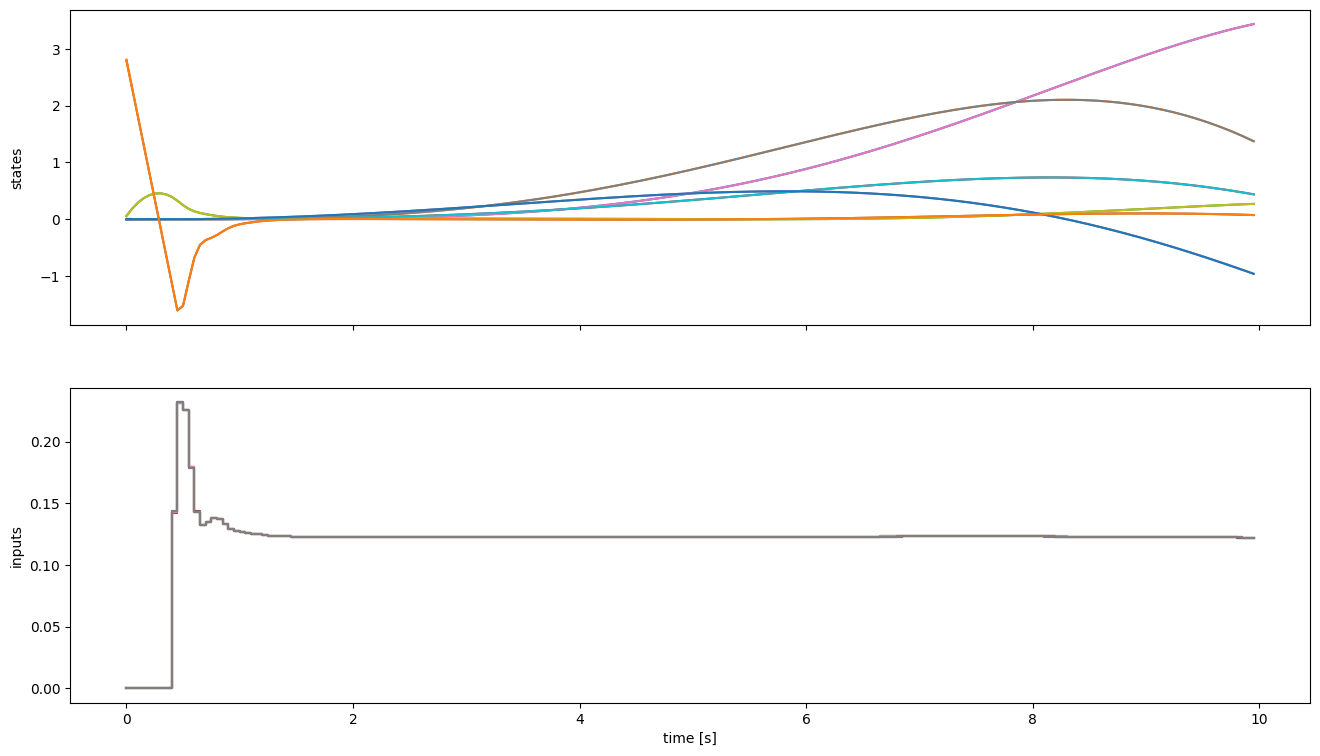

In [13]:
qo = Quad3DOptimizer(qr)
qo.p_dynamics()
qo.simulate()

In [14]:
def safe_mkdir_recursive(directory, overwrite=False):
    if not os.path.exists(directory):
        try:
            os.makedirs(directory)
        except OSError as exc:
            if exc.errno == errno.EEXIST and os.path.isdir(directory):
                pass
            else:
                raise
    else:
        if overwrite:
            try:
                shutil.rmtree(directory)
            except:
                print('Error while removing directory: {0}'.format(directory))

In [15]:
# create ocp object to formulate the OCP
ocp = AcadosOcp()

ocp.acados_include_path = acados_path + '/include'
ocp.acados_lib_path = acados_path + '/lib'

# set model

dynamics = qo.quad_dynamics()(x=qo.x, u=qo.u)['x_dot']

f_impl = qo.x_dot - dynamics

model = AcadosModel()

model.f_impl_expr = f_impl
model.f_expl_expr = dynamics

model.x = qo.x
model.xdot = model
model.u = qo.u
model.p = []
model.z = []
model.name = 'Drone'

# model = ocp.model

Tf = qo.T
nx = model.x.size()[0]
nu = model.u.size()[0]
ny = nx + nu
ny_e = nx
# n_param = model.p.size()[0]

# set dimensions
ocp.model = model
ocp.dims.N = qo.N

# set cost
Q = 2*np.diag(qo.q_diagonal)
R = 2*np.diag(qo.r_diagonal)

ocp.cost.cost_type = 'LINEAR_LS'
ocp.cost.cost_type_e = 'LINEAR_LS'

ocp.cost.W = np.diag(np.concatenate((qo.q_diagonal, qo.r_diagonal)))
ocp.cost.W_e = np.diag(qo.q_diagonal) #block_diag(Q, R)

ocp.cost.Vx = np.zeros((ny, nx))
ocp.cost.Vx[:nx, :nx] = np.eye(nx)
ocp.cost.Vu = np.zeros((ny, nu))
ocp.cost.Vu[-4:, -4:] = np.eye(nu)

ocp.cost.Vx_e = np.eye(nx)

x_ref = np.zeros(nx)
ocp.cost.yref = np.concatenate((x_ref, np.array([0.0, 0.0, 0.0, 0.0])))
ocp.cost.yref_e = x_ref

# Initial state (will be overwritten)
ocp.constraints.x0 = qo.quad.get_state()

# Set constraints
ocp.constraints.lbu = np.array([qo.min_u] * 4)
ocp.constraints.ubu = np.array([qo.max_u] * 4)
ocp.constraints.idxbu = np.array([0, 1, 2, 3])

# set options
ocp.solver_options.qp_solver = 'FULL_CONDENSING_HPIPM' # FULL_CONDENSING_QPOASES
ocp.solver_options.hessian_approx = 'GAUSS_NEWTON'
ocp.solver_options.integrator_type = 'ERK'
ocp.solver_options.print_level = 0
ocp.solver_options.nlp_solver_type = 'SQP_RTI' # SQP_RTI, SQP

# set prediction horizon
ocp.solver_options.tf = Tf

safe_mkdir_recursive(os.path.join(cwd, 'acados_models'))

json_file = os.path.join(cwd, 'acados_models', 'acados_ocp.json')
ocp_solver = AcadosOcpSolver(ocp, json_file = json_file)

simX = np.ndarray((qo.N+1, nx))
simU = np.ndarray((qo.N, nu))

status = ocp_solver.solve()

if status != 0:
    ocp_solver.print_statistics() # encapsulates: stat = ocp_solver.get_stats("statistics")
    raise Exception(f'acados returned status {status}.')

# get solution
for i in range(qo.N):
    simX[i,:] = ocp_solver.get(i, "x")
    simU[i,:] = ocp_solver.get(i, "u")
simX[qo.N,:] = ocp_solver.get(qo.N, "x")

ocp_solver.print_statistics() # encapsulates: stat = ocp_solver.get_stats("statistics")

 If there is an incompatibility with the CasADi generated code, please consider changing your CasADi version.
Version 3.5.6 currently in use.


RuntimeError: .../casadi/core/sx_function.cpp:148: Code generation of 'Drone_expl_ode_fun' is not possible since variables [dx, dy, dz, q1, wx, q2, wy, q3, wz, q0, wx, q2, wz, q3, wy, q0, wy, q1, wz, q3, wx, q0, wz, q1, wy, q2, wx, q0, q2, q1, q3, u0, u1, u2, u3, q0, q1, q2, q3, u0, u1, u2, u3, q1, q2, u0, u1, u2, u3, u1, u3, wy, wz, u0, u2, wx, wz, u0, u1, u2, u3] are free.

In [ ]:

model.f_expl_expr

SX(@1=0.5, @2=2, @3=20, @4=-2, @5=156.667, @6=4.33333, [dx, dy, dz, ((((-0.5*q1)*wx)-((@1*q2)*wy))-((@1*q3)*wz)), ((((@1*q0)*wx)+((@1*q2)*wz))-((@1*q3)*wy)), ((((@1*q0)*wy)-((@1*q1)*wz))+((@1*q3)*wx)), ((((@1*q0)*wz)+((@1*q1)*wy))-((@1*q2)*wx)), ((((@2*q0)*q2)+((@2*q1)*q3))*((((@3*u0)+(@3*u1))+(@3*u2))+(@3*u3))), ((((@4*q0)*q1)+((@2*q2)*q3))*((((@3*u0)+(@3*u1))+(@3*u2))+(@3*u3))), (((((@4*sq(q1))-(@2*sq(q2)))+1)*((((@3*u0)+(@3*u1))+(@3*u2))+(@3*u3)))-9.81), (((@5*u1)-(@5*u3))-(wy*wz)), (((@5*u0)-(@5*u2))+(wx*wz)), ((((-4.33333*u0)+(@6*u1))-(@6*u2))+(@6*u3))])